# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../../data/input/input_dataset.csv')

df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,Referee,Day Of Week,Round,Days,Shots,ShotsOT,Corners,Fouls,YCards,RCards,GoalsScored,GoalsConceded,GoalsDiff,HTGoalsScored,HTGoalsConceded,HTGoalsDiff,Points,WinPercent,WinStreak,UnbPercent,UnbStreak,Def,Mid,Att,Ovr,LastSeasonRank,PromotedMatchup,WinnerOdd,DrawOdd,Venue,Result
0,L Probert,Sat,1.0,-4,10.4,6.6,3.8,-1.8,0.0,0.0,0.8,0.4,2.0,0.0,0.4,-2.0,0.4,20.0,0.0,0.0,1.0,7,8,8,7.67,-12,0,-9.71,5.50,Etihad Stadium,W
1,M Halsey,Sat,1.0,1,-1.0,-0.2,0.0,-1.8,0.4,0.0,0.2,0.0,1.0,0.4,0.2,1.0,-0.2,0.0,0.0,-20.0,-1.0,1,1,-2,0.00,1,0,-2.25,3.30,Bet365 Stadium,D
2,L Mason,Sat,1.0,0,6.8,5.0,1.8,-0.2,0.4,0.2,1.6,0.6,5.0,1.4,1.0,2.0,0.4,0.0,0.0,40.0,7.0,3,0,-1,0.67,-6,0,-6.56,4.20,Goodison Park,W
3,L Probert,Sun,1.0,0,3.4,2.2,2.0,0.2,-0.6,0.0,1.8,0.6,6.0,0.4,0.4,0.0,1.0,20.0,0.0,60.0,5.0,1,2,1,1.34,-4,0,-3.58,3.75,Craven Cottage,L
4,P Dowd,Sun,1.0,-1,-2.4,-1.8,-0.6,0.6,-1.0,0.0,-0.4,-1.2,4.0,0.2,0.0,1.0,1.0,20.0,0.0,60.0,6.0,-1,-3,-5,-3.00,-1,0,-1.50,3.30,Carrow Road,W


In [4]:
# label encode categorical feature- Day Of Week
dayOfWeek_le = LabelEncoder()
df['Day Of Week'] = dayOfWeek_le.fit_transform(df['Day Of Week'])

# label encode categorical feature- Referee
referee_le = LabelEncoder()
df['Referee'] = referee_le.fit_transform(df['Referee'])

# label encode categorical feature- Venue
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

# 3. Feature Selection

In [5]:
selected_features = ['Referee', 'Shots', 'Corners', 'Points', 'UnbStreak', 'LastSeasonRank', 'PromotedMatchup', 'Venue']

# 4. Model Building- Data Split 7

- Target Variable: Win/ Non-Win
- Stratified Sampling

### Random Forest Classifier

#### Hyperparameter Tuning using Fold 1

In [6]:
# data splitting
train_set = pd.read_csv('./fold-1/train.csv')
test_set = pd.read_csv('./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

classifier = RandomForestClassifier(random_state = 0)
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100}


#### Fold 1

In [70]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='log2', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv('./fold-1/train.csv')
test_set = pd.read_csv('./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1440
0    1197
Name: Result, dtype: int64
1    361
0    299
Name: Result, dtype: int64


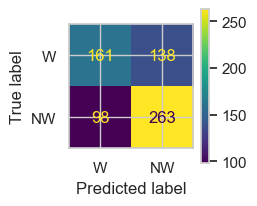

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [73]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6424242424242425
ROC score on Test Set: 0.7079971094785018

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       299
           1       0.66      0.73      0.69       361

    accuracy                           0.64       660
   macro avg       0.64      0.63      0.63       660
weighted avg       0.64      0.64      0.64       660



#### Fold 2

In [74]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='log2', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


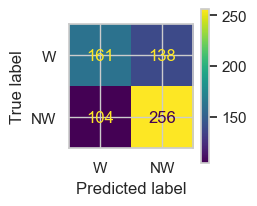

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [76]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6327769347496206
ROC score on Test Set: 0.6855072463768115

              precision    recall  f1-score   support

           0       0.61      0.54      0.57       299
           1       0.65      0.71      0.68       360

    accuracy                           0.63       659
   macro avg       0.63      0.62      0.62       659
weighted avg       0.63      0.63      0.63       659



#### Fold 3

In [77]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='log2', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


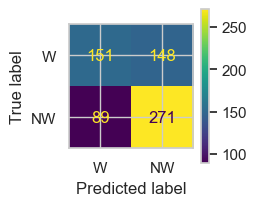

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [79]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6403641881638846
ROC score on Test Set: 0.6918849869936826

              precision    recall  f1-score   support

           0       0.63      0.51      0.56       299
           1       0.65      0.75      0.70       360

    accuracy                           0.64       659
   macro avg       0.64      0.63      0.63       659
weighted avg       0.64      0.64      0.63       659



#### Fold 4

In [80]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='log2', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


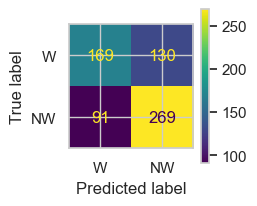

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [82]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6646433990895296
ROC score on Test Set: 0.7020903010033445

              precision    recall  f1-score   support

           0       0.65      0.57      0.60       299
           1       0.67      0.75      0.71       360

    accuracy                           0.66       659
   macro avg       0.66      0.66      0.66       659
weighted avg       0.66      0.66      0.66       659



#### Fold 5

In [83]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=3, max_features='log2', n_estimators=100, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

1    1441
0    1196
Name: Result, dtype: int64
1    360
0    300
Name: Result, dtype: int64


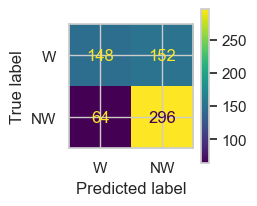

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [85]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)[:, 1]
# y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6727272727272727
ROC score on Test Set: 0.7448703703703704

              precision    recall  f1-score   support

           0       0.70      0.49      0.58       300
           1       0.66      0.82      0.73       360

    accuracy                           0.67       660
   macro avg       0.68      0.66      0.66       660
weighted avg       0.68      0.67      0.66       660



### Logistic Regression

#### Hyperparameter Tuning using Fold 1

In [9]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.03359818286283781, 'penalty': 'l1', 'solver': 'liblinear'}


#### Fold 1

In [86]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1440
0    1197
Name: Result, dtype: int64
1    361
0    299
Name: Result, dtype: int64


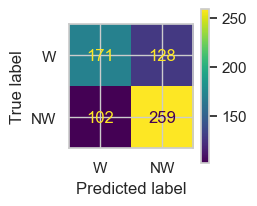

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [88]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6515151515151515
ROC score on Test Set: 0.711874299372794

              precision    recall  f1-score   support

           0       0.63      0.57      0.60       299
           1       0.67      0.72      0.69       361

    accuracy                           0.65       660
   macro avg       0.65      0.64      0.65       660
weighted avg       0.65      0.65      0.65       660



#### Fold 2

In [89]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


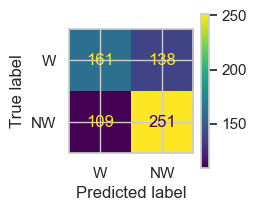

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [91]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6251896813353566
ROC score on Test Set: 0.6785488665923449

              precision    recall  f1-score   support

           0       0.60      0.54      0.57       299
           1       0.65      0.70      0.67       360

    accuracy                           0.63       659
   macro avg       0.62      0.62      0.62       659
weighted avg       0.62      0.63      0.62       659



#### Fold 3

In [92]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


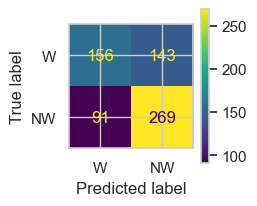

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [94]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.644916540212443
ROC score on Test Set: 0.693998513563731

              precision    recall  f1-score   support

           0       0.63      0.52      0.57       299
           1       0.65      0.75      0.70       360

    accuracy                           0.64       659
   macro avg       0.64      0.63      0.63       659
weighted avg       0.64      0.64      0.64       659



#### Fold 4

In [95]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


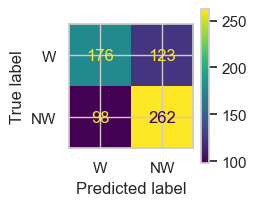

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [97]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6646433990895296
ROC score on Test Set: 0.7108695652173913

              precision    recall  f1-score   support

           0       0.64      0.59      0.61       299
           1       0.68      0.73      0.70       360

    accuracy                           0.66       659
   macro avg       0.66      0.66      0.66       659
weighted avg       0.66      0.66      0.66       659



#### Fold 5

In [98]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0336, penalty='l1', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

1    1441
0    1196
Name: Result, dtype: int64
1    360
0    300
Name: Result, dtype: int64


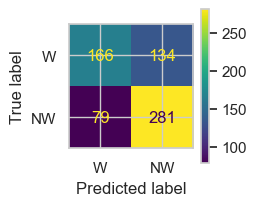

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [100]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6772727272727272
ROC score on Test Set: 0.7378703703703704

              precision    recall  f1-score   support

           0       0.68      0.55      0.61       300
           1       0.68      0.78      0.73       360

    accuracy                           0.68       660
   macro avg       0.68      0.67      0.67       660
weighted avg       0.68      0.68      0.67       660



### SVM Classifier

#### Hyperparameter Tuning using Fold 1

In [8]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 1, 'tol': 1e-300}


#### Fold 1

In [101]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=1e-300, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1440
0    1197
Name: Result, dtype: int64
1    361
0    299
Name: Result, dtype: int64


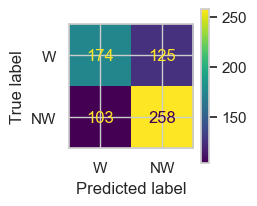

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [103]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6545454545454545
ROC score on Test Set: 0.7133751470738103

              precision    recall  f1-score   support

           0       0.63      0.58      0.60       299
           1       0.67      0.71      0.69       361

    accuracy                           0.65       660
   macro avg       0.65      0.65      0.65       660
weighted avg       0.65      0.65      0.65       660



#### Fold 2

In [104]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=1e-300, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


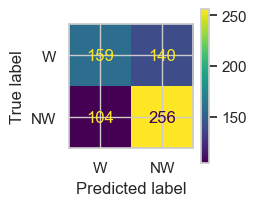

In [105]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [106]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.629742033383915
ROC score on Test Set: 0.68173541434411

              precision    recall  f1-score   support

           0       0.60      0.53      0.57       299
           1       0.65      0.71      0.68       360

    accuracy                           0.63       659
   macro avg       0.63      0.62      0.62       659
weighted avg       0.63      0.63      0.63       659



#### Fold 3

In [107]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=1e-300, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


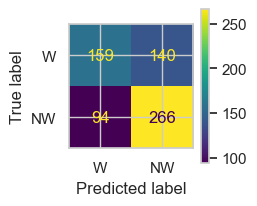

In [108]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [109]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.644916540212443
ROC score on Test Set: 0.6943050910442214

              precision    recall  f1-score   support

           0       0.63      0.53      0.58       299
           1       0.66      0.74      0.69       360

    accuracy                           0.64       659
   macro avg       0.64      0.64      0.64       659
weighted avg       0.64      0.64      0.64       659



#### Fold 4

In [110]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=1e-300, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


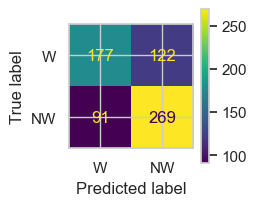

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [112]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6767830045523521
ROC score on Test Set: 0.7130806391675957

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       299
           1       0.69      0.75      0.72       360

    accuracy                           0.68       659
   macro avg       0.67      0.67      0.67       659
weighted avg       0.68      0.68      0.67       659



#### Fold 5

In [113]:
# Linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=1, tol=1e-300, random_state=0, dual=False))
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

1    1441
0    1196
Name: Result, dtype: int64
1    360
0    300
Name: Result, dtype: int64


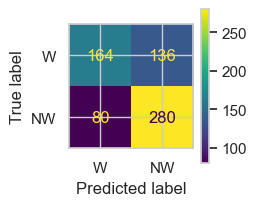

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [115]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6727272727272727
ROC score on Test Set: 0.7326481481481482

              precision    recall  f1-score   support

           0       0.67      0.55      0.60       300
           1       0.67      0.78      0.72       360

    accuracy                           0.67       660
   macro avg       0.67      0.66      0.66       660
weighted avg       0.67      0.67      0.67       660



### XGBoost Classifier

#### Hyperparameter Tuning using Fold 1

In [7]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 60}


#### Fold 1

In [116]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=6, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1440
0    1197
Name: Result, dtype: int64
1    361
0    299
Name: Result, dtype: int64


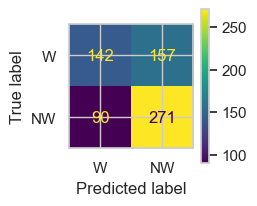

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [118]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6257575757575757
ROC score on Test Set: 0.6722083769536498

              precision    recall  f1-score   support

           0       0.61      0.47      0.53       299
           1       0.63      0.75      0.69       361

    accuracy                           0.63       660
   macro avg       0.62      0.61      0.61       660
weighted avg       0.62      0.63      0.62       660



#### Fold 2

In [119]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=6, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


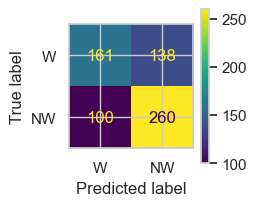

In [120]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [121]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6388467374810318
ROC score on Test Set: 0.6861296915644741

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       299
           1       0.65      0.72      0.69       360

    accuracy                           0.64       659
   macro avg       0.64      0.63      0.63       659
weighted avg       0.64      0.64      0.64       659



#### Fold 3

In [122]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=6, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


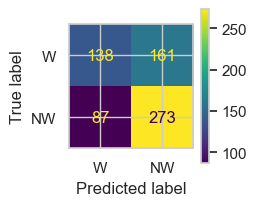

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [124]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6236722306525038
ROC score on Test Set: 0.6597918989223337

              precision    recall  f1-score   support

           0       0.61      0.46      0.53       299
           1       0.63      0.76      0.69       360

    accuracy                           0.62       659
   macro avg       0.62      0.61      0.61       659
weighted avg       0.62      0.62      0.61       659



#### Fold 4

In [125]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=6, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1441
0    1197
Name: Result, dtype: int64
1    360
0    299
Name: Result, dtype: int64


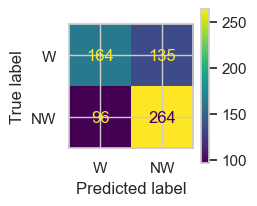

In [126]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [127]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6494688922610015
ROC score on Test Set: 0.6843088071348941

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       299
           1       0.66      0.73      0.70       360

    accuracy                           0.65       659
   macro avg       0.65      0.64      0.64       659
weighted avg       0.65      0.65      0.65       659



#### Fold 5

In [128]:
# XGBoost regression
xgb_classifier = XGBClassifier(learning_rate=0.01, max_depth=6, n_estimators=60)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'W': 0, 'NW': 1})
y_test = y_test.map({'W': 0, 'NW': 1})

# numerical encode using the appropriate scaler
wnw_sc = StandardScaler()
X_train.iloc[:, 1:-2] = wnw_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = wnw_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

1    1441
0    1196
Name: Result, dtype: int64
1    360
0    300
Name: Result, dtype: int64


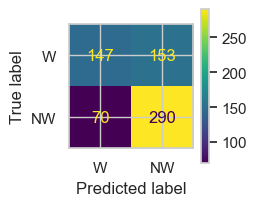

In [129]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(2, 2))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['W', 'NW'])
cmp.plot(ax=ax)

plt.show()

In [130]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)[:, 1]
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.6621212121212121
ROC score on Test Set: 0.7160879629629631

              precision    recall  f1-score   support

           0       0.68      0.49      0.57       300
           1       0.65      0.81      0.72       360

    accuracy                           0.66       660
   macro avg       0.67      0.65      0.65       660
weighted avg       0.66      0.66      0.65       660

